In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import os 

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff
from plotting_support import explode_volume

# LOAD MODEL, RECS, DATA

In [2]:
# modelling params
dx = dy = dz = 0.01
nx = nz = 50
ny=50
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

npad = 0
FS = False 

sloc = np.array([0.25, 0.25, 0.25]) # in m
sloc_gp = ((sloc/dx)-1).astype('int')

nrec = 150
dt = 1e-6
nt = 1000


In [3]:
inpath = '../../SOFI-modelling/SOFI_LabImitiation/'

In [4]:
vp_mod = np.fromfile(os.path.join(inpath,'inputs/model/lab_sample.vp'),dtype='float32').reshape((nx,ny,nz))
recs = np.loadtxt(os.path.join(inpath,'inputs/receiver.dat')).T

# Seismic Data
data_1d = np.loadtxt(os.path.join(inpath,'outputs/su/test_div.txt'), delimiter="\n")
nt_orig = int(data_1d.shape[0]/nrec)
data = data_1d.reshape((nrec,nt_orig)) 
data = data[:,:nt+250]

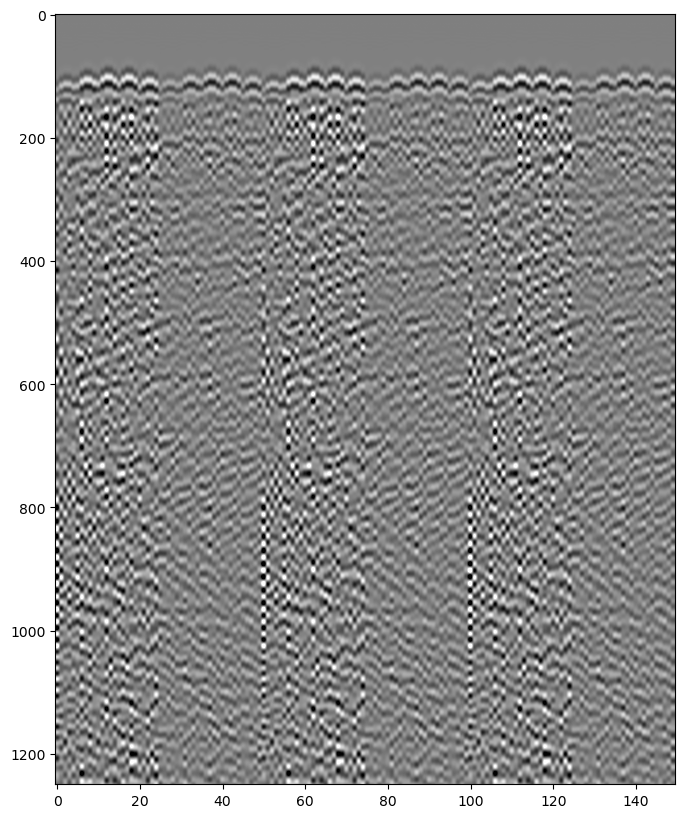

In [5]:
vlim=np.percentile(data,99.5)
              
plt.figure(figsize=[8,10])
plt.imshow(data.T, aspect='auto', cmap='binary', vmin=-vlim, vmax=vlim)

# MAKE DATA

40


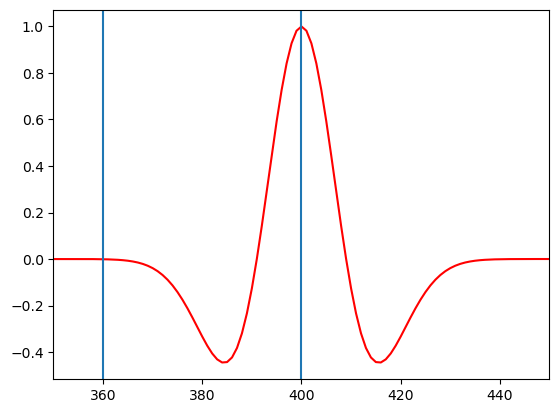

In [6]:
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:401], f0=2.5e4)
plt.plot(wav, 'r')
plt.axvline(360)
plt.axvline(wavc)
plt.xlim(350, 450)
print(wavc-360)

In [7]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=int(vp_mod[0,0,0]), 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=16175.349586405764 - u^H(Op^Hv)=16175.34958640579


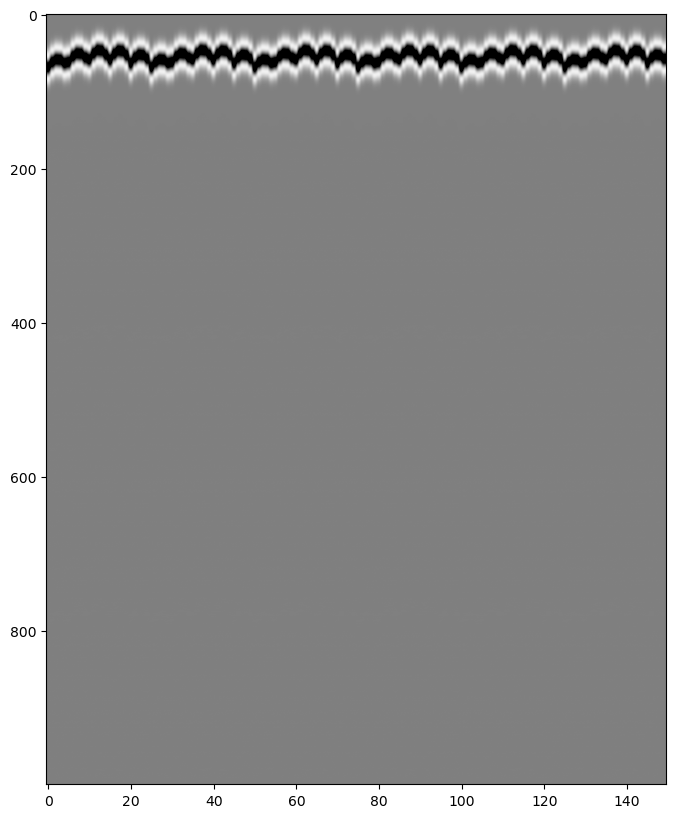

In [8]:
microseismic = np.zeros_like(vp_mod)
microseismic[25, 25, 25] = 1.

# PERFORM FORWARD (MODEL)
frwd_data = Op @ microseismic.flatten().squeeze()
frwd_data_o = frwd_data.reshape([nrec,nt])

plt.figure(figsize=[8,10])
plt.imshow(frwd_data_o.T, aspect='auto', cmap='binary', vmin=-0.5, vmax=0.5)


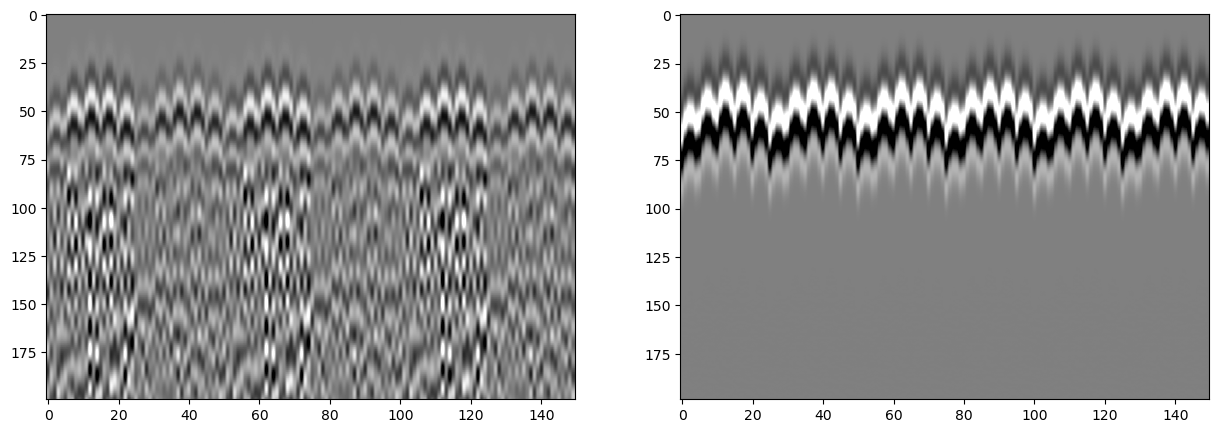

In [9]:
fig,axs = plt.subplots(1,2,figsize=[15,5])
axs[0].imshow(data[:,60:260].T, aspect='auto', cmap='binary', vmin=-vlim, vmax=vlim)
axs[1].imshow(-np.diff(frwd_data_o[:,:200].T, axis=0), aspect='auto', cmap='binary', vmin=-0.1, vmax=0.1)

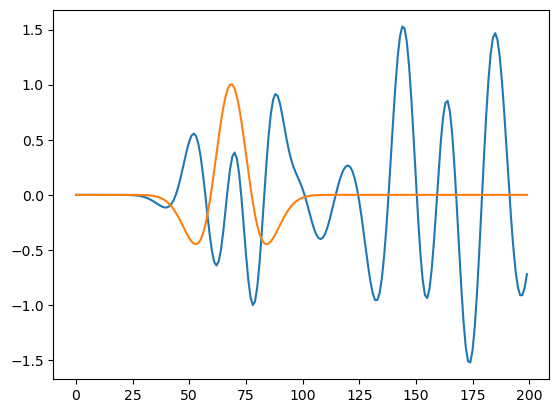

In [10]:
plt.plot(data[0,60:260]/np.max(abs(data[0,:200])))
plt.plot(frwd_data_o[0,:200]/np.max(abs(frwd_data_o[0,:200])))
# plt.plot(-np.diff(frwd_data_o[0,:200])/np.max(abs(np.diff(frwd_data_o[0,:200]))))

# ADD TIME SHIFT ON SOFI DATA

Text(0.5, 1.0, 'Forward: Point Receivers')

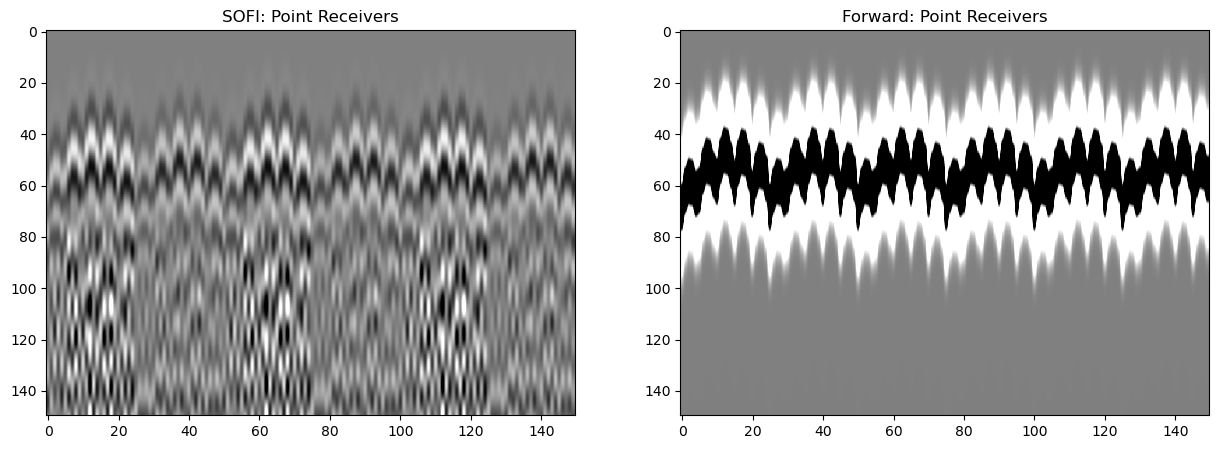

In [11]:
shft = 60
fd_data = data[:,shft:shft+nt]
frwd_data = frwd_data_o[:,:1000]
# frwd_data = np.zeros_like(fd_data)
# frwd_data[:,:999] = -np.diff(frwd_data_o, axis=1)

fig,axs = plt.subplots(1,2,figsize=[15,5])
axs[0].imshow(fd_data[:,:150].T, aspect='auto', cmap='binary', vmin=-vlim, vmax=vlim)
axs[1].imshow(frwd_data[:,:150].T, aspect='auto', cmap='binary', vmin=-0.1, vmax=0.1)

axs[0].set_title('SOFI: Point Receivers')
axs[1].set_title('Forward: Point Receivers')

In [12]:
frwd_data.shape

(150, 1000)

In [13]:
# PERFORM ADJOINT (MIGRATE)
mig_fd_1d = Op.H @ fd_data.ravel().squeeze()
mig_frwd_1d = Op.H @ frwd_data.ravel().squeeze()

mig_fd_pr = mig_fd_1d.reshape(nx,ny,nz)
mig_frwd_pr = mig_frwd_1d.reshape(nx,ny,nz)

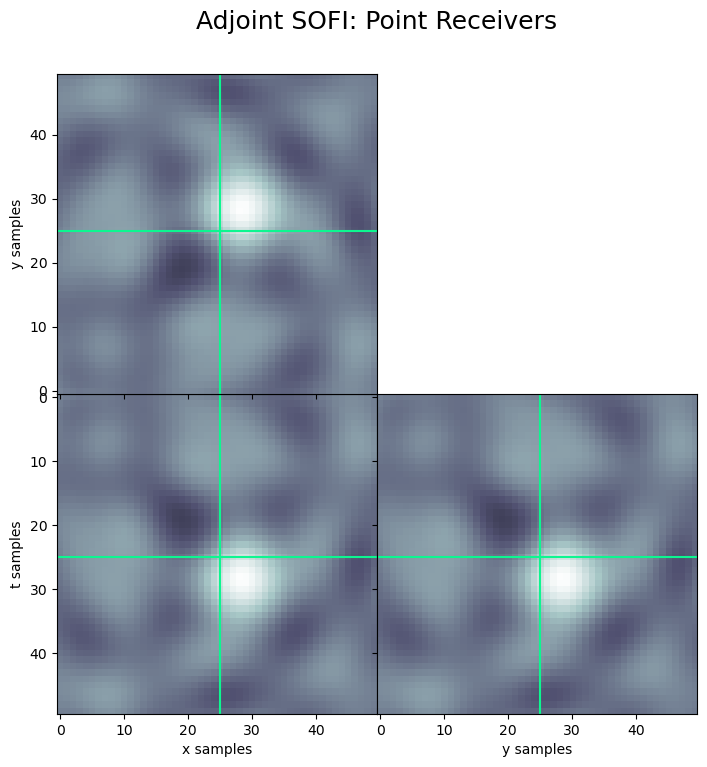

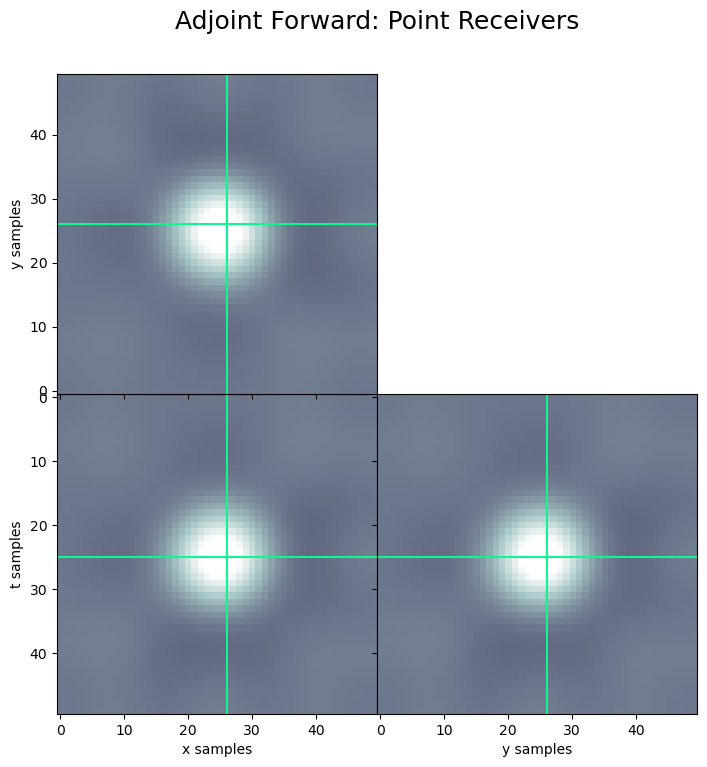

In [14]:
fig,axs = explode_volume(mig_fd_pr.transpose(2,1,0), p=99.9, 
                         x=25,y=25)
fig.suptitle('Adjoint SOFI: Point Receivers', fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_frwd_pr.transpose(2,1,0), p=99.9, 
                         x=26,y=26)
fig.suptitle('Adjoint Forward: Point Receivers', fontsize=18)
fig.tight_layout()


# DAS VERSION

In [15]:
n_faces = 6
nr_x = 5
# LINE A
RLA_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,2,3],
                      axis=0
                     )
SLA_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# LINE B
RLB_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[2,3,4,5],
                      axis=0
                     )
SLB_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# LINE C
RLC_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,4,5],
                      axis=0
                     )
SLC_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# COMBINING OPERATORS
Vop = VStack([SLA_Op.H @ SLA_Op @ RLA_Op, 
              SLB_Op.H @ SLB_Op @ RLB_Op,
              SLC_Op.H @ SLC_Op @ RLC_Op
             ])

LinesOp = Vop * Op

# check operator with dottest
_ = dottest(LinesOp, verb=True)

Dot test passed, v^H(Opu)=-578.1086158448052 - u^H(Op^Hv)=-578.1086158449034


In [16]:
n_faces = 6
fd_face_data = fd_data.reshape(n_faces,nr_x,nr_x,nt)
frwd_face_data = frwd_data.reshape(n_faces,nr_x,nr_x,nt)


In [17]:
# FORWARD MODEL DATA USING SUM AND SPREAD
# lines_frwddata = LinesOp @ microseismic.flatten()

(3, 4, 5, 5, 1000)


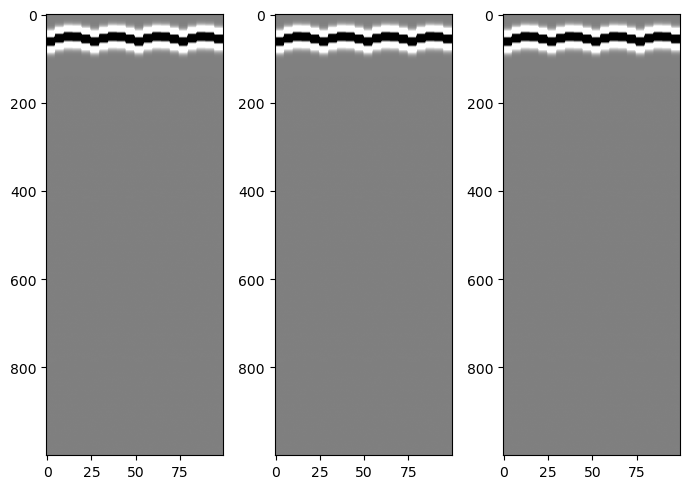

In [18]:
# CHECKING I GET THE DATA I WANT
aveLAdata = SLA_Op.H @ SLA_Op @ RLA_Op @ fd_face_data
aveLBdata = SLB_Op.H @ SLB_Op @ RLB_Op @ fd_face_data
aveLCdata = SLC_Op.H @ SLC_Op @ RLC_Op @ fd_face_data
lines_fddata = np.concatenate([aveLAdata,aveLBdata,aveLCdata],axis=0).reshape([3,4,nr_x,nr_x,nt])
print(lines_fddata.shape)

# CHECKING I GET THE DATA I WANT
aveLAdata = SLA_Op.H @ SLA_Op @ RLA_Op @ frwd_face_data
aveLBdata = SLB_Op.H @ SLB_Op @ RLB_Op @ frwd_face_data
aveLCdata = SLC_Op.H @ SLC_Op @ RLC_Op @ frwd_face_data
lines_frwddata = np.concatenate([aveLAdata,aveLBdata,aveLCdata],axis=0).reshape([3,4,nr_x,nr_x,nt])

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(aveLAdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(aveLBdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(aveLCdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

In [19]:
4*3*nr_x*nr_x

300

Text(0.5, 1.0, 'Forward: Pseudo-DAS')

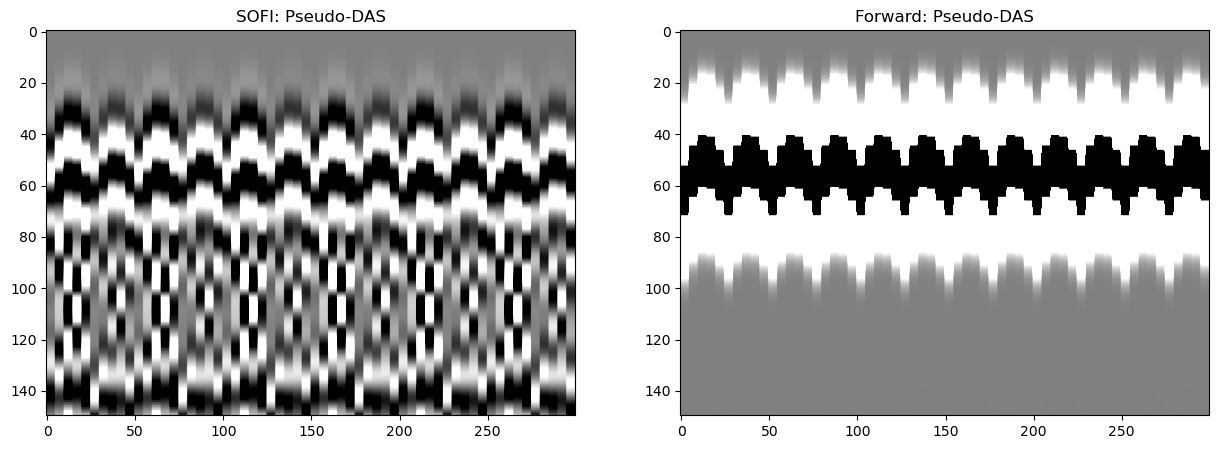

In [20]:
lines_fddata_recstyle = lines_fddata.reshape(4*3*nr_x*nr_x,nt)
lines_frwddata_recstyle = lines_frwddata.reshape(4*3*nr_x*nr_x,nt)

fig,axs = plt.subplots(1,2,figsize=[15,5])
axs[0].imshow(lines_fddata_recstyle[:,:150].T, aspect='auto', cmap='binary', vmin=-vlim, vmax=vlim)
axs[1].imshow(lines_frwddata_recstyle[:,:150].T, aspect='auto', cmap='binary', vmin=-0.1, vmax=0.1)

axs[0].set_title('SOFI: Pseudo-DAS')
axs[1].set_title('Forward: Pseudo-DAS')

In [21]:
# PERFORM ADJOINT (MIGRATE)
mig_fd_1d = LinesOp.H @ lines_fddata.flatten()
mig_fd_pd = mig_fd_1d.reshape(nx,ny,nz)
mig_fd_pd /= np.max(abs(mig_fd_pd))

mig_frwd_1d = LinesOp.H @ lines_frwddata.flatten()
mig_frwd_pd = mig_frwd_1d.reshape(nx,ny,nz)
mig_frwd_pd /= np.max(abs(mig_frwd_pd))

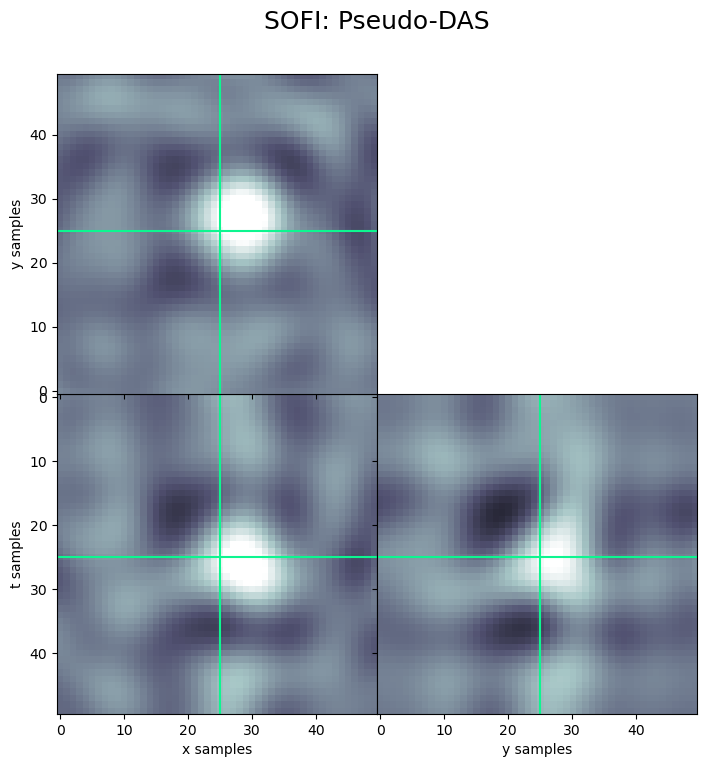

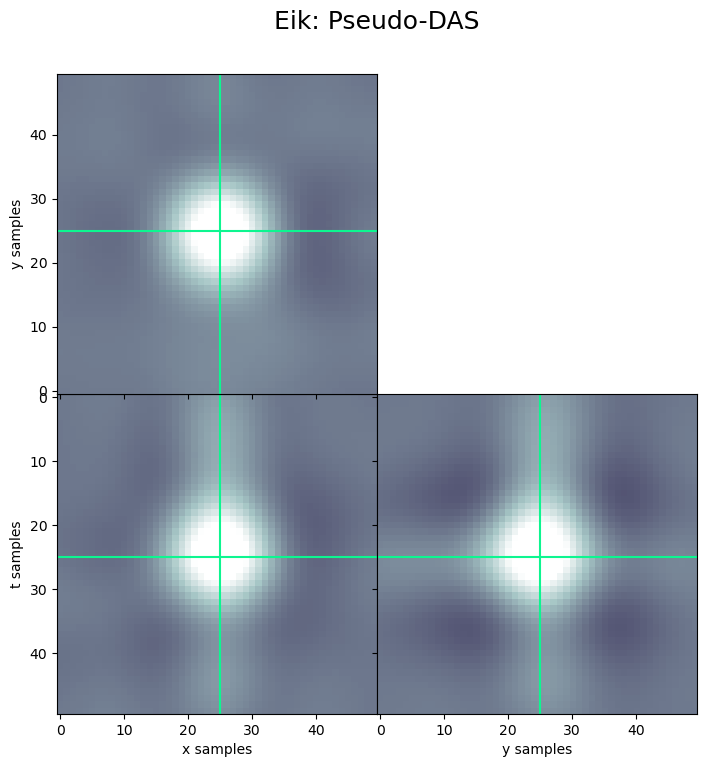

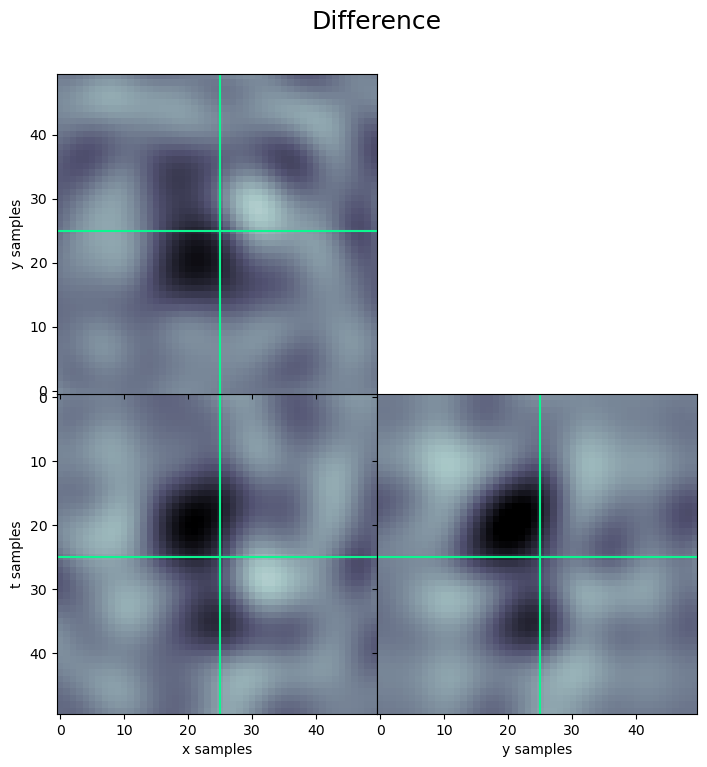

In [22]:
vlim=0.75

fig,axs = explode_volume(mig_fd_pd.transpose(2,1,0), clipval=[-vlim,vlim],
                         x=25,y=25, t=25)
fig.suptitle('SOFI: Pseudo-DAS', fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_frwd_pd.transpose(2,1,0), clipval=[-vlim,vlim], 
                         x=25,y=25, t=25)
fig.suptitle('Eik: Pseudo-DAS', fontsize=18)
fig.tight_layout()

fig,axs = explode_volume((mig_fd_pd-mig_frwd_pd).transpose(2,1,0), clipval=[-vlim,vlim], 
                         x=25,y=25, t=25)
fig.suptitle('Difference', fontsize=18)
fig.tight_layout()